In [1]:
# Loading Credentials from local file;
# this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 5:  Example Case - Analyzing Gustav von Schmoller</font>

In this notebook, we follow a more hypothesis driven and ego-centered graph approach to work with the SoNAR (IDH) data for historical network analysis. 
In this notebook, we investigate an example case in the field of economics. We are going to analyze the network of the German economist [Gustav von Schmoller](https://en.wikipedia.org/wiki/Gustav_von_Schmoller).



We want to investigate two main questions: 

1. What are the connections of Gustav von Schmoller to Berlin Politics?
2. How well was Schmoller connected within the academic community?

In [2]:
import networkx as nx
from neo4j import GraphDatabase
from helper_functions.helper_fun import to_nx_graph
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import count
from matplotlib.colors import rgb2hex
from matplotlib.colors import rgb2hex 
from matplotlib.patches import Circle 
import matplotlib.pyplot as plt 

# Who is Gustav von Schmoller?

We start off by gathering some general information about Schmoller. What was his profession? Where did he come from? Where did he work?

## When did Schmoller live?

In [3]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In [4]:
print("Date of Birth of Schmoller:", list(nx.get_node_attributes(G, "DateStrictBegin").values())[0])
print("Date of Death of Schmoller:", list(nx.get_node_attributes(G, "DateStrictEnd").values())[0])

Date of Birth of Schmoller: 24.06.1838
Date of Death of Schmoller: 27.06.1917


Gustav von Schmoller lived in the 19th and the beginning of the 20th century and was 79 years old when he died.

## What was Schmollers profession? 

Now we know when Schmoller lived, but what was his profession? To answer this question, we need to retrieve the connected topic terms of Schmoller. Topic terms connected to persons usually represent the profession of the respective person.

In [5]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToTopicTerm]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In [6]:
topicterms = [x for x, y in G.nodes(data=True) if y['type'] == "TopicTerm"]

for term in topicterms:
    print(G.nodes(data=True)[term]["Name"])

Volkswirt
Wirtschaftswissenschaftler
Sozialwissenschaftler
Hochschullehrer


Schmoller was an academic, he was (macro) economist, social scientist and university professor.

## What geographic places are connected to Schmoller?

What are the places Schmoller has connections to? Where did he work? Where was he born, and where did he die?

In [7]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToGeoName]-(g:GeoName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In [8]:
place_of_birth = [target for source, target, attribute in G.edges(
    data=True) if attribute['SourceType'] == 'placeOfBirth']
place_of_death = [target for source, target, attribute in G.edges(
    data=True) if attribute['SourceType'] == 'placeOfDeath']
places_of_activity = [[source, target] for source, target, attribute in G.edges(
    data=True) if attribute['SourceType'] == 'placeOfActivity']

# we need to refine the result of the places of activity a little further
# currently there can be the node (2923000) of Schmoller in the results. Therefor we need to filter out the node of him
places_of_activity = [
    place for sublist in places_of_activity for place in sublist if place != 2923000]

# let's print the results:
print("Place of Birth:", G.nodes(data=True)[place_of_birth[0]]["Name"])
print("Place of Death:", G.nodes(data=True)[place_of_death[0]]["Name"])
print("")
print("Places of Activity:")
for place in places_of_activity:
    print(G.nodes(data=True)[place]["Name"])

Place of Birth: Heilbronn
Place of Death: Bad Harzburg

Places of Activity:
Straßburg
Halle (Saale)
Berlin


He was born in Heilbronn and he died in Bad Harzburg. He has professional connections to Straßburg, Halle (Saale) and Berlin. 
Let's also query with which corporations Schmoller is directly connected

In [9]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToCorpName]-(c:CorpName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In [10]:
[y["Name"] for x, y in G.nodes(data=True) if y["type"] == "CorpName"]

['Königliche Akademie der Wissenschaften']

Schmoller was member of the Royal Academy of Sciences.

Alright, in the next section we go on with his personal relations.

## With whom was Schmoller in contact?

Schmoller was an academic, he was a university professor, and he lived in different places during his life. This sounds like he was able to build quite some connections during his life. 

Let's see if this assumption is true. To which persons did Schmoller have direct connections according to the SoNAR database?

In [11]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378" AND rel.SourceType = "correspondedRelation"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In the query above, we also retrieve the topic terms of the people Schmoller has a social relation to. These topic terms tell us the respective profession of the retrieved nodes again. 

Furthermore we apply a filter for `rel.SourceType = "correspondedRelation"`. This way we only retrieve people that Schmoller corresponded with.

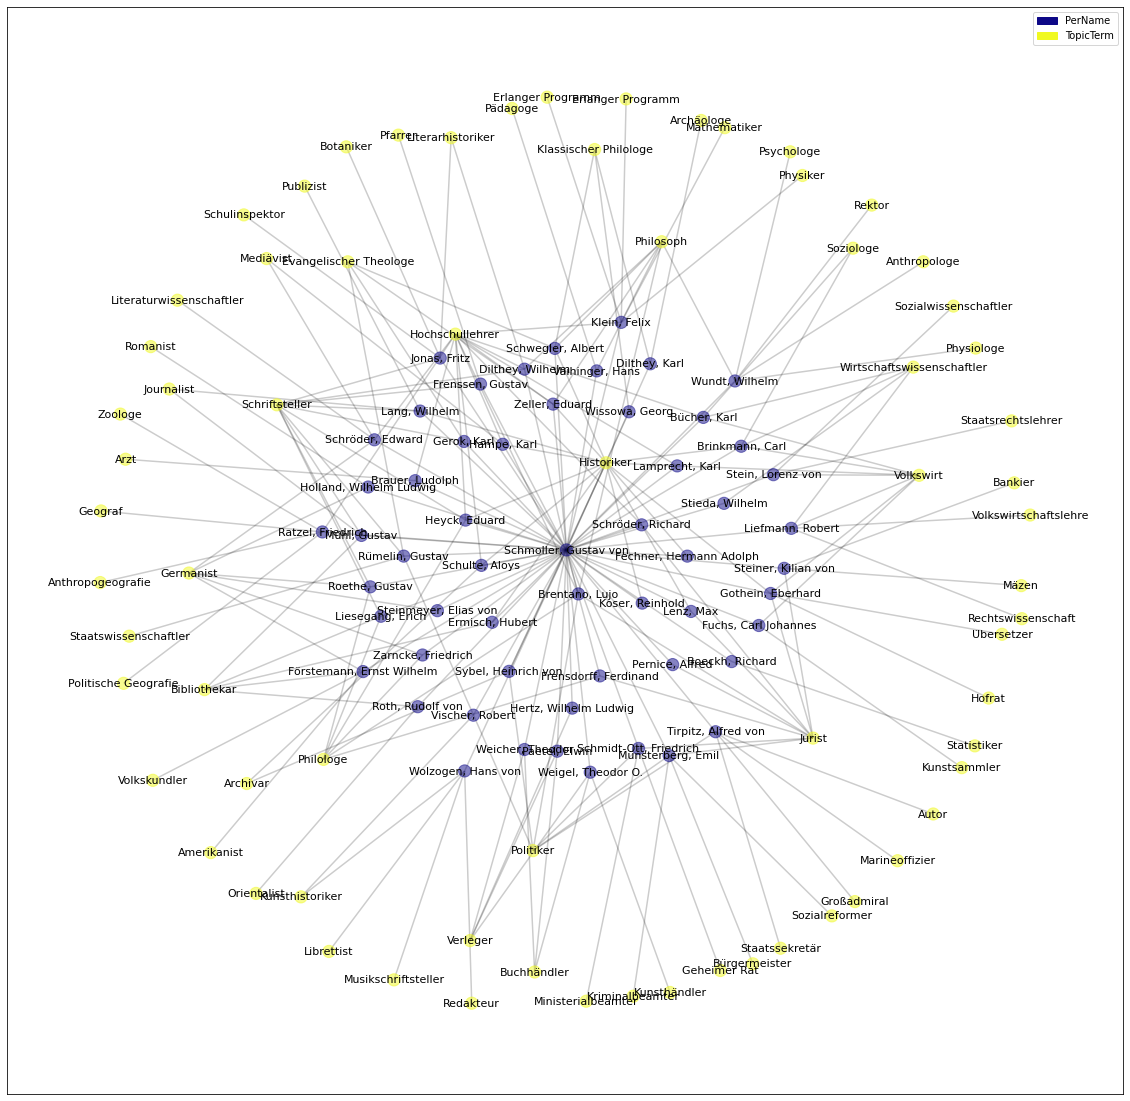

In [12]:
node_labels = nx.get_node_attributes(G, "label")

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.kamada_kawai_layout(G)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(G, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[G.nodes()[n][node_color_attribute]] for n in G.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[20, 20])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(G, **node_options)

## draw the labels
nx.draw_networkx_labels(G, **node_label_options)

## draw the edges
nx.draw_networkx_edges(G, **edge_options)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

We can tell from the network visualization that Schmoller had a lot of connections to a lot of academics from a wide range of different scientific fields. 

Now we want to get a more precise overview of his connections by aggregating the connected `topicTerms` of the persons he had relationships with. 
Let's create a data frame that provides us the information about the node type and the node label (name) of each of the nodes:

In [13]:
types_dict = nx.get_node_attributes(G, "type")
label_dict = nx.get_node_attributes(G, "label")

types_df = pd.DataFrame.from_dict(types_dict, orient="index", columns=["type"])
label_df = pd.DataFrame.from_dict(
    label_dict, orient="index", columns=["label"])

schmoller_contacts_df = pd.concat([types_df, label_df], axis=1)
schmoller_contacts_df

,type,label
2923000,PerName,"Schmoller, Gustav von"
2834694,PerName,"Liesegang, Erich"
51586460,TopicTerm,Bibliothekar
51565992,TopicTerm,Schriftsteller
51623002,TopicTerm,Philologe
...,...,...
51560168,TopicTerm,Autor
2854581,PerName,"Weicher, Theodor"
3005380,PerName,"Steiner, Kilian von"
51745298,TopicTerm,Mäzen


The next step we need to do is filtering for all `TopicTerm` nodes and calculating the degree centrality for each of the nodes. 

In [14]:
# create new df with those rows only that have a type of "TopicTerm"
topicterms_df = schmoller_contacts_df[schmoller_contacts_df["type"] == "TopicTerm"]

# create a dictionary that contains all the degree values of the topic terms
degree_dict = dict(G.degree(topicterms_df.index.tolist()))

# make a dataframe out of the degree dictionary
degree_df = pd.DataFrame.from_dict(
    degree_dict, orient="index", columns=["degree"])

# add the degree values as a new variable to the topicterms_df
connections_degree_df = pd.concat([topicterms_df, degree_df], axis=1)

# sort the data frame by degree in descending order
connections_degree_df.sort_values("degree", ascending=False)

,type,label,degree
51562647,TopicTerm,Historiker,14
51562669,TopicTerm,Hochschullehrer,13
51565992,TopicTerm,Schriftsteller,10
51563092,TopicTerm,Jurist,9
51617740,TopicTerm,Volkswirt,7
...,...,...,...
51601402,TopicTerm,Kunstsammler,1
51629389,TopicTerm,Romanist,1
51689269,TopicTerm,Staatswissenschaftler,1
51587285,TopicTerm,Botaniker,1


Gustav von Schmoller was in contact with quite some historians. Who are these historians?

In [15]:
# get the node id of the topicterm node "Historiker"
historian_term_id = topicterms_df.loc[topicterms_df["label"]
                                      == "Historiker"].index[0]

# get all neighbors (connected nodes) of the historian node
historians_node_ids = [n for n in G.neighbors(historian_term_id)]

# Print the name of the historians Schmoller was in contact with
[y["Name"] for x, y in G.nodes(data=True) if x in historians_node_ids]

['Heyck, Eduard',
 'Lamprecht, Karl',
 'Schulte, Aloys',
 'Lang, Wilhelm',
 'Koser, Reinhold',
 'Zeller, Eduard',
 'Schwegler, Albert',
 'Lenz, Max',
 'Hampe, Karl',
 'Gothein, Eberhard',
 'Fechner, Hermann Adolph',
 'Ermisch, Hubert',
 'Brinkmann, Carl',
 'Sybel, Heinrich von']

Awesome, this could be an interesting starting point for the investigation of his academic network. But more on that in [Chapter 3](#How-does-the-academic-network-of-Schmoller-look-like?).

At first, we jump into his connections to Berlin politics.

# What connections does Schmoller have to Berlin Politics?

In this chapter we ask ourselves the question if Schmoller was connected to Berlin politics and with whom he was in contact with. 

Our approach to retrieve the relevant data from the SoNAR (IDH) database is to query every person that is connected to either the `TopicTerm` "Politikerin" or the male counterpart "Politiker". We can use this result afterwards to keep only those persons that also have a relationship to Schmoller and Berlin. 

The query below uses the same structure as the query we used in Chapter 1.1 in Notebook 4 of this curriculum. Please read up the explanation in Notebook 4 in case you are confused how the Cypher query in the code block below works.


The politics related topic terms we need are the following ones: 

* `TopicTerm Id` for "Politiker": `(DE-588)4046517-2`

* `TopicTerm Id` for "Politikerin": `(DE-588)4175019-6` 

In [16]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)--(t:TopicTerm)
WHERE t.Id IN ["(DE-588)4046517-2", "(DE-588)4175019-6"] 
WITH DISTINCT [x in collect(n)|id(x)] as collectedIds
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2:RelationToGeoName]-(g:GeoName)
WHERE (n.Id = "(DE-588)118609378") AND (id(n2) IN collectedIds) AND (g.Name CONTAINS "Berlin")
RETURN n, rel, n2
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

Alright, let's have a look at the network we just queried:

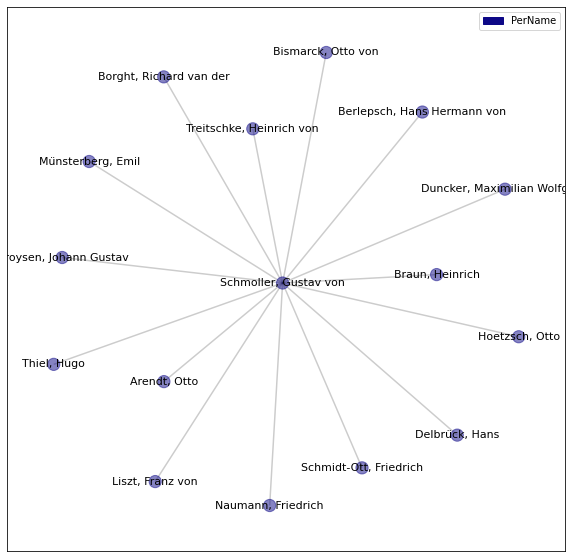

In [17]:
node_labels = nx.get_node_attributes(G, "label")

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.spring_layout(G)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(G, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[G.nodes()[n][node_color_attribute]] for n in G.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[10,10])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(G, **node_options)

## draw the labels
nx.draw_networkx_labels(G, **node_label_options)

## draw the edges
nx.draw_networkx_edges(G, **edge_options)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

Schmoller is directly connected to 15 politicians that have a connection to Berlin. Now we can investigate what these relationships are about.

We can use the `SourceType` attribute of the edges to get a better understanding of how the nodes are connected:

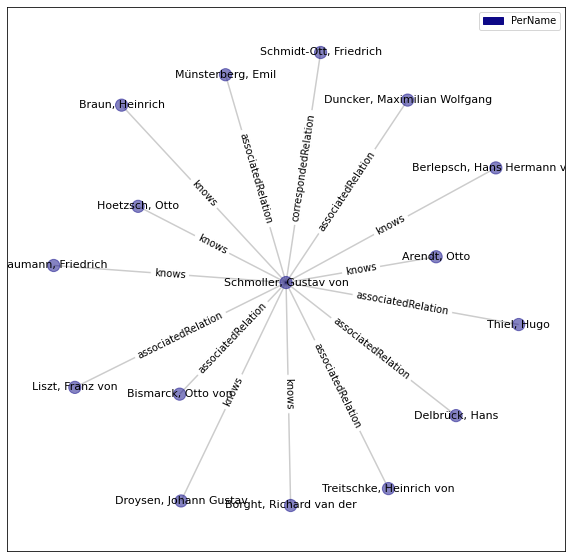

In [18]:
edge_labels = nx.get_edge_attributes(
    G, "SourceType")  # retrieve the edge labels

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.spring_layout(G)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(G, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[G.nodes()[n][node_color_attribute]] for n in G.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[10,10])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(G, **node_options)

## draw the labels
nx.draw_networkx_labels(G, **node_label_options)

## draw the edges
nx.draw_networkx_edges(G, **edge_options)

## draw edge labels
nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_labels)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

We are analyzing the `SocialRelations` of Schmoller. The social relations in the SoNAR (IDH) database have very specific characteristics since they are derived from resources like diaries or letters. We retrieved three different types of social relations for Schmoller, namely `knows`, `associatedRelation` and `correspondedRelation`. The table below provides some information on what these relationship types mean:


|Type|Meaning|
|:--|--|
|`knows`|Derived from diary entries, albums or family registers|
|`associatedRelation`|Inference of a social relation|
|`correspondedRelation`| Derived from letters and other correspondences|


We can use the attribute `Source` of `SocialRelations` to get the ID of the node the `SocialRelation` was derived from. 

Let's check two examples in more detail. In the network visualization above, we can see that Schmoller `knows` Hans Hermann von Berlepsch. Berlepsch was an administrative lawyer and politician in the Kingdom of Prussia. How do Schmoller and Berlepsch know each other?

At first, we extract the `Source` attribute from the relation between Schmoller and Berlepsch. We can use this source attribute now as a filter for the next database query. The `knows` attribute is derived from a diary or a family album. So we need to query `Resource` nodes to find the document that connects Schmoller and Berlepsch.

In [19]:
[y["Name"] for x, y in G.nodes(data=True)]

['Schmoller, Gustav von',
 'Berlepsch, Hans Hermann von',
 'Hoetzsch, Otto',
 'Naumann, Friedrich',
 'Treitschke, Heinrich von',
 'Liszt, Franz von',
 'Duncker, Maximilian Wolfgang',
 'Braun, Heinrich',
 'Bismarck, Otto von',
 'Droysen, Johann Gustav',
 'Delbrück, Hans',
 'Schmidt-Ott, Friedrich',
 'Thiel, Hugo',
 'Münsterberg, Emil',
 'Arendt, Otto',
 'Borght, Richard van der']

Let's investigate the relationship of Schmoller with Hans Hermann von Berlepsch. We know, there is a relationship between Schmoller and Berlepsch. This relationship links to a `Resource` node that connects both people. When we want to investigate their relationship further, we need to identify this `Resource` node at first. 

In [20]:
# the line below defines the target person's name
target_person = "Berlepsch, Hans Hermann von"

# Now we can extract the "Source" attribute from the relationship between Schmoller (the source) and Berlepsch (the target)
source = [attribute["Source"] for source, target, attribute in G.edges(data=True) if (G.nodes(
    data=True)[source]["Id"] == "(DE-588)118609378") and (G.nodes(data=True)[target]["Name"] == target_person)]

In [21]:
source[0]

'BibDE_611_HS_3090549'

Now we run a query against the database to get all relevant nodes and their relationships with the resource we identified above. 

In [22]:
query = """
MATCH (res:Resource)-[rel:SocialRelation|RelationToPerName|RelationToTopicTerm]-(n)
WHERE res.id = "{source}" 
WITH DISTINCT [x in collect(res)+collect(n)|id(x)] as collectedIds
MATCH (n)-[rel:SocialRelation|RelationToPerName|RelationToTopicTerm]-(n2)
WHERE ID(n) in collectedIds AND ID(n2) in collectedIds
RETURN n,n2,rel
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

schmoller_berlepsch_graph = to_nx_graph(neo4j_driver=driver,
                                        query=query.format(source=source[0]))

Let's visualize the graph:

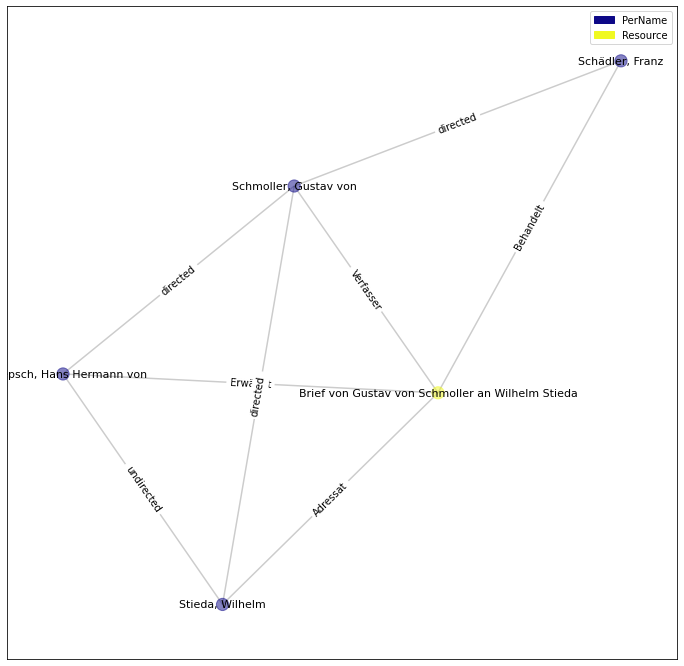

In [23]:
edge_labels = nx.get_edge_attributes(
    schmoller_berlepsch_graph, "TypeAddInfo")  # retrieve the edge labels

node_labels_names = nx.get_node_attributes(schmoller_berlepsch_graph, "Name")
node_labels_titles = nx.get_node_attributes(schmoller_berlepsch_graph, "Title")
node_labels = {**node_labels_names, **node_labels_titles}

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.spring_layout(schmoller_berlepsch_graph)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(schmoller_berlepsch_graph, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[schmoller_berlepsch_graph.nodes()[n][node_color_attribute]] for n in schmoller_berlepsch_graph.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[12,12])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(schmoller_berlepsch_graph, **node_options)

## draw the labels
nx.draw_networkx_labels(schmoller_berlepsch_graph, **node_label_options)

## draw the edges
nx.draw_networkx_edges(schmoller_berlepsch_graph, **edge_options)

## draw edge labels
nx.draw_networkx_edge_labels(schmoller_berlepsch_graph, pos = pos, edge_labels=edge_labels)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

This graph visualization of the connection between Schmoller and Berlepsch gives us quite some interesting information. Let's go through it real quick: 

The central resource the graph is based on is a letter from Schmoller to Stieda. More information onn this specific letter can be found in the [Kalliope Catalogue](http://kalliope-verbund.info/DE-611-HS-3090549). The node of this resource contains the "Uri" attribute - this URI is pointing to detailed source information. 

Schmoller is the author ("Verfasser") of a letter to Wilhelm Stieda ("Brief von Gustav von Schmoller an Wilhelm Stieda"). So Wilhelm Stieda is the receiver of the letter ("Adressat"). This is why there is a directed relation between Schmoller and Stieda - Schmoller wrote (at least) one letter to Stieda.

We also have a lot of information derived from the content of the letter. The letter is about Franz Schädler  ("behandelt") but also Berlepsch is mentioned ("erwähnt") in the letter. And thus we know that Schmoller knows about Berlepsch and Schädler because he explicitly wrote about them in the letter to Stieda and hence his relations to Berlepsch and Schädler are directed. 
Wilhelm Stieda (probably) read the letter, and thus he also indirectly (*undirected*) knows about the existence of Berlepsch and Schädler.

Now, let's check what information we have about Franz Schädler in the database. He seems to be of importance to Schmoller. 

In [24]:
query = """
MATCH (n:PerName {Id: "(DE-588)134102126"})-[rel:RelationToTopicTerm]-(t:TopicTerm)
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

schaedler_graph = to_nx_graph(neo4j_driver=driver,
                              query=query)

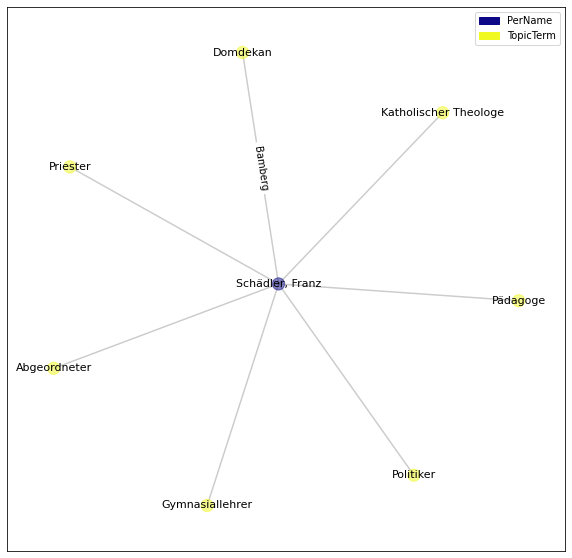

In [26]:
node_labels = nx.get_node_attributes(schaedler_graph, "label")

edge_labels = nx.get_edge_attributes(schaedler_graph, "TypeAddInfo")

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.spring_layout(schaedler_graph)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(schaedler_graph, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[schaedler_graph.nodes()[n][node_color_attribute]] for n in schaedler_graph.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[10,10])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(schaedler_graph, **node_options)

## draw the labels
nx.draw_networkx_labels(schaedler_graph, **node_label_options)

## draw the edges
nx.draw_networkx_edges(schaedler_graph, **edge_options)

## draw edge labels
nx.draw_networkx_edge_labels(schaedler_graph, pos = pos, edge_labels=edge_labels)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

As we can see, Franz Schädler was theologian, teacher and also politician and member of the Reichstag. This could be a good starting point to investigate this trace further by looking up the original letter from Schmoller to Stieda and see what he actually wrote about Berlepsch and Schädler.

Similarly, we could now go on and investigate Schmollers relations to the other people in his network. But let's move on to the next topic for now. 

## 📝 Exercise

Task:

1. Find out what resource connects Schmoller to Otto von Bismarck.
2. Query the graph of the resource node you identified in Task 1 and visualize the graph.

# How does the academic network of Schmoller look like?

We could proceed to investigate the question of Schmollers academic relations in a similar way we did with politicians. The difficulty in the academic field however is the presence of plenty of different field names, people can be working in. So it's not as simple as defining one or two `TopicTerms` we are interested in but we would need to create a big list of `TopicTerms` we want to cover in the network. 

This is why we use a slightly different focus in the following analysis. We want to know the relations of Schmoller to other university Professors. The following questions will guide our analysis: 

1. Is Schmoller predominantly connected to Professors that worked at the same universities as he did?
2. In what fields academic fields are the professors he knows working?
3. Is there one person Schmoller published the most publications with?


In [Chapter 1.4](#With-whom-was-Schmoller-in-contact) we created a data frame of all `TopicTerms` that are connected to people schmoller knows. Let's check this table once more for "Professor:in" or "Hochschullehrer:in" (male or female professors).

In [38]:
print(
    schmoller_contacts_df[schmoller_contacts_df["label"].str.contains("rofessor")])
print(
    schmoller_contacts_df[schmoller_contacts_df["label"].str.contains("lehrer")])

Empty DataFrame
Columns: [type, label]
Index: []
               type               label
51562669  TopicTerm     Hochschullehrer
51613384  TopicTerm  Staatsrechtslehrer


The only relevant term in the general contacts Graph of Schmoller for university professors is "Hochschullehrer" so we go on with this term. In the next step, we query every person that is connected to the `TopicTerm` "Hochschullehrer" and that has a connection to Schmoller.

In [27]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (t:TopicTerm)--(n:PerName)-[rel]-(n2:PerName {Id: "(DE-588)118609378"})
WHERE t.Name CONTAINS "Hochschullehrer"
WITH DISTINCT [x in collect(n)+collect(n2)|id(x)] as collectedIds
MATCH (n:PerName)-[rel:RelationToCorpName]-(c:CorpName)
WHERE ID(n) in collectedIds
RETURN n,rel,c
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

We need to extract the node IDs of all `GeoName` nodes and afterwards we can calculate the degree values of these nodes to see how many people are attached to each place.

In [28]:
university_names = {x: y["Name"]
                    for x, y in G.nodes(data=True) if y["type"] == "CorpName"}
university_names_df = pd.DataFrame.from_dict(
    university_names, orient="index", columns=["university"])

university_degrees = dict(G.degree(university_names_df.index.tolist()))
university_degrees_df = pd.DataFrame.from_dict(
    university_degrees, orient="index", columns=["degree"])

university_degrees_df = pd.concat(
    [university_names_df, university_degrees_df], axis=1).sort_values("degree", ascending=False)
university_degrees_df.head()

,university,degree
156599,Monumenta Germaniae Historica,5
145536,Universität Heidelberg,5
145390,Christian-Albrechts-Universität zu Kiel,5
95582,Friedrich-Wilhelms-Universität Berlin,3
145530,Universität Leipzig,3


At the top places we see the universities of Heidelberg, Berlin and Kiel. Schmoller has work related relations in the database to Straßburg, Halle and Berlin - so his academic networks spreads over different places in Germany. 

Now, let's investigate further in what academic fields the other professors are working in:

In [29]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (t:TopicTerm)--(n:PerName)-[rel]-(n2:PerName {Id: "(DE-588)118609378"})
WHERE t.Name CONTAINS "Hochschullehrer"
WITH DISTINCT [x in collect(n)+collect(n2)|id(x)] as collectedIds
MATCH (n:PerName)-[rel:RelationToTopicTerm]-(t:TopicTerm)
WHERE ID(n) in collectedIds
RETURN n,rel,t
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

In [30]:
profession_names = {x: y["Name"]
                    for x, y in G.nodes(data=True) if y["type"] == "TopicTerm"}
profession_names_df = pd.DataFrame.from_dict(
    profession_names, orient="index", columns=["term"])

profession_degrees = dict(G.degree(profession_names_df.index.tolist()))
profession_degrees_df = pd.DataFrame.from_dict(
    profession_degrees, orient="index", columns=["degree"])

profession_degrees_df = pd.concat(
    [profession_names_df, profession_degrees_df], axis=1).sort_values("degree", ascending=False)
profession_degrees_df.head(6)

,term,degree
51562669,Hochschullehrer,50
51617740,Volkswirt,17
51562647,Historiker,16
51567773,Wirtschaftswissenschaftler,9
51565198,Politiker,7
51689269,Staatswissenschaftler,7


Schmoller is very well connected with economists ("Volkswirt", "Wirtschaftswissenschaftler"), historians as well as political scientists ("Staatswissenschaftler").

The last analysis is this notebook is the investigation of the network around the works he published. We will query the resources only, since this is the kind of publications Schmoller predominantly has relations to. When you investigate another person, make sure to check the `UniTitle` nodes as well. 

In [31]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (r:Resource)-[rel]-(n:PerName {Id: "(DE-588)118609378"})
WITH DISTINCT [x in collect(r)|id(x)] as collectedIds
MATCH (r:Resource)-[rel2:RelationToPerName]-(n2:PerName)
WHERE ID(r) IN collectedIds 
RETURN r, rel2, n2
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver=driver,
                query=query)

How many resources and how many people are in the graph?

In [32]:
print("Number of Resources: ", len(
    [x for x, y in G.nodes(data=True) if y["type"] == "Resource"]))
print("Number of Persons: ", len(
    [x for x, y in G.nodes(data=True) if y["type"] == "PerName"]))

Number of Resources:  763
Number of Persons:  558


Let's take a look at the resources in the graph that have a genre attribute. This can tell us something about what Schmoller wrote most.

In [33]:
genres = [y["Genre"] for x, y in G.nodes(data=True) if "Genre" in y]

genres_df = pd.DataFrame(genres, columns=["genre"])
genres_df.head()

,genre
0,Zeitschrift;;;Zeitschrift
1,Zeitschrift
2,Zeitschrift;;;Zeitschrift
3,Aufsatzsammlung
4,Bildnis;;;Einblattdruck


As we can see, the genre variable contains a special character format to provide multiple information (e.g. `"Bildnis;;;Einblattdruck"`). It's easier for us to clean this variable up a little, so we get a better idea of what genres are in the graph. 

In the code cell below, we apply some regex to the genre-variable to extract only the very first word when there are semicolons in the genre name. This is a very simplistic approach to clean this variable, it might be necessary to use a more complex data cleaning approach for other tasks. 

In [34]:
genres_df["genre"] = genres_df["genre"].str.extract(r"(^[a-zA-Z]*)")

# and now we can aggregate the frame to get the total count per genre
genres_df.value_counts("genre").head(10)

genre
Brief               449
Dokument             55
Quelle               23
Hochschulschrift      9
Bildnis               8
Korrespondenz         7
Werk                  6
Aufsatzsammlung       6
Zeitschrift           6
Briefe                4
dtype: int64

As we can see, letters are the biggest group of Schmollers resources that connect him to other academics. But there are other genres that can be interesting to analyze, too. 

We can take a look into the correspondences Schmoller had for example:

In [35]:
documents_ids = [x for x, y in G.nodes(
    data=True) if "Genre" in y and y["Genre"].startswith("Korrespondenz")]

documents_neighbors = []
for i in range(len(documents_ids)):
    documents_neighbors.extend(
        [node for node in nx.all_neighbors(G, documents_ids[i])])

documents_neighbors.extend(documents_ids)
documents_subgraph = G.subgraph(documents_neighbors)

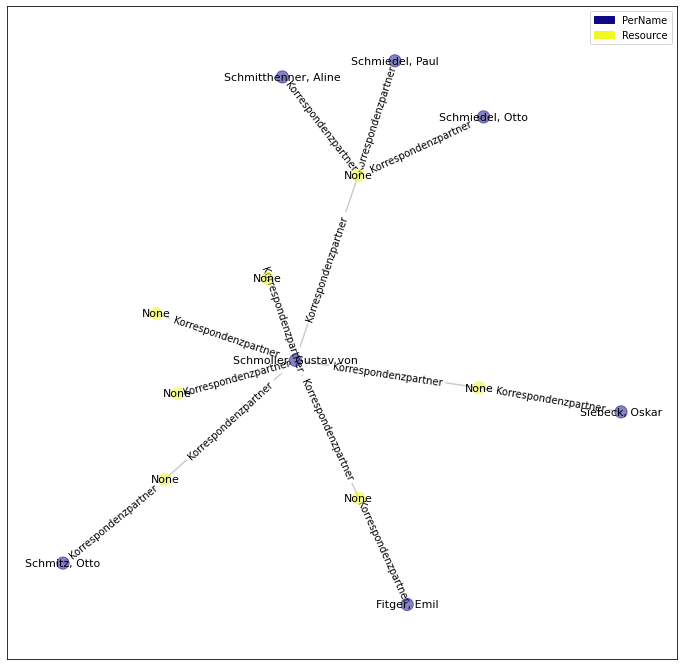

In [38]:
node_labels = nx.get_node_attributes(documents_subgraph, "label")

edge_labels = nx.get_edge_attributes(documents_subgraph, "TypeAddInfo")

# defining general variables
## we start off by setting the position of nodes and edges again
pos = nx.spring_layout(documents_subgraph)

## set the color map to be used
color_map = plt.cm.plasma

# setup node_colors
node_color_attribute = "type"

groups = set(nx.get_node_attributes(documents_subgraph, node_color_attribute).values())
group_ids = np.array(range(len(groups)))
if len(group_ids) > 1:
    group_ids_norm = (group_ids - np.min(group_ids))/np.ptp(group_ids)
else:
    group_ids_norm = group_ids
mapping = dict(zip(groups, group_ids_norm))
node_colors = [mapping[documents_subgraph.nodes()[n][node_color_attribute]] for n in documents_subgraph.nodes()]


# defining the graph options & styling
## dictionary for node options:
node_options = {
        "pos":  pos,
        "alpha": 1,
        "node_size": 150,
        "alpha": 0.5,
        "node_color":  node_colors, # here we set the node_colors object as an option
        "cmap": color_map # this cmap defines the color scale we want to use
    }

## dictionary for edge options:
edge_options = {
                "pos": pos,
                "width": 1.5,
                "alpha": 0.2,
        }

## dictionary for node label options: 
node_label_options = {
            "pos": pos,
            "labels": node_labels,
            "font_size": 11
        }


## set plot size and plot margins
plt.figure(figsize=[12,12])
plt.margins(x=0.1, y = 0.1)

# draw the graph
## draw the nodes
nx.draw_networkx_nodes(documents_subgraph, **node_options)

## draw the labels
nx.draw_networkx_labels(documents_subgraph, **node_label_options)

## draw the edges
nx.draw_networkx_edges(documents_subgraph, **edge_options)

## draw edge labels
nx.draw_networkx_edge_labels(documents_subgraph, pos = pos, edge_labels=edge_labels)


# create custom legend according to color_map
geom_list = [Circle([], color = rgb2hex(color_map(float(mapping[term])))) for term in groups]
plt.legend(geom_list, groups)

# show the plot
plt.show()

## 📝 Exercise


Tasks:

1. Create a graph that visualizes Schmollers network around his "Hochschulschriften" resources.
2. With which topic term are those people most connected, Schmoller wrote letters to? 


Congratulations! 🎉 You reached the end of the SoNAR (IDH) Curriculum. Now you should be able to conduct your own HNA with the SoNAR data. This curriculum provided an overview of methods and code snippets to conduct simple to more complex analyses. Still, this is just an introduction and there are many more things for you to discover in the field of network analysis.